В текущем ноутбуке мы попробуем разработать модель для расчёта выбросов CO2 для разных *типов транспорта* и *маршрутов*. Другими словами, необходимо построить предсказательную модель, которая будет учитывать различные факторы, в том числе тип транспорта, дальность маршрута, груз и вес груза.


Какие шаги предстоит сделать?

================= EDA. Продолжение ================
* изучить ещё раз данные, чтобы определить, какую метрику взять за таргет (возможно, её придётся предварительно добавить)

================= Feature Engineering ================
* какие векторы числовых признаков и векторы категориальных признаков могут быть полезны при построении модели, а какие стоит удалить, т.к. они окажутся излишними
* как закодировать категориальные признаки

================= Model Training & Evaluation ==========
* выбрать модель для тренировки
* обучить модель
* проверить на тестовом наборе
* расписать выводы

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

# EDA. Продолжение

In [52]:
train = pd.read_csv('logistics_dataset_train.csv', index_col=0)
train.head()

,origin,destination,distance_km,transport_type,transport_type_code,cargo_weight_tons,commodity,commodity_code,year,ton_km,emission_factor_g_tkm,co2_emissions_kg,co2_per_liter,fuel_consumption_liters,co2_per_km,co2_per_ton_km,fuel_efficiency_l_per_100km,environmental_class
5308987,Rest of CT,Boston MA-RI-NH-CT (RI Part),0.107267,multiple modes & mail,5,0.000030,Base metals,32,2021,0.000003,12,3.861600e-08,3.10,1.245677e-08,3.600000e-07,0.012,0.000012,low
11730566,Rest of MN,New Orleans LA-MS (LA Part),2.177995,truck,1,0.001872,Waste/scrap,41,2024,0.004077,71,2.894816e-04,2.68,1.080155e-04,1.329120e-04,0.071,0.004959,medium
6562794,Albany NY CFS Area,Dallas-Fort Worth TX-OK (TX Part),2.300792,air (include truck-air),4,0.000207,Electronics,35,2021,0.000476,570,2.714705e-04,3.15,8.618110e-05,1.179900e-04,0.570,0.003746,high
2083785,Corpus Christi TX,Rest of OH,2.342930,truck,1,0.000513,Motorized vehicles,36,2019,0.001202,71,8.533653e-05,2.68,3.184199e-05,3.642300e-05,0.071,0.001359,medium
3731953,Indianapolis IN,Baltimore MD,0.979051,truck,1,0.169873,Electronics,35,2020,0.166314,71,1.180831e-02,2.68,4.406087e-03,1.206098e-02,0.071,0.450037,medium


In [53]:
copy = train.copy()
# Переименуем столбец co2_emission_kg: общий объём выбросов во время рейса

In [55]:
len(copy.co2_emissions_kg.unique())

174080

In [56]:
# Заранее закодируем environmental class, чтобы посмотреть, как он связан с другими числовыми метриками
encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])
copy['environmental_class'] = encoder.fit_transform(copy[['environmental_class']])

In [57]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 5308987 to 4171578
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   origin                       300000 non-null  object 
 1   destination                  300000 non-null  object 
 2   distance_km                  300000 non-null  float64
 3   transport_type               300000 non-null  object 
 4   transport_type_code          300000 non-null  int64  
 5   cargo_weight_tons            300000 non-null  float64
 6   commodity                    300000 non-null  object 
 7   commodity_code               300000 non-null  int64  
 8   year                         300000 non-null  int64  
 9   ton_km                       300000 non-null  float64
 10  emission_factor_g_tkm        300000 non-null  int64  
 11  co2_emissions_kg             300000 non-null  float64
 12  co2_per_liter                300000 non-null  float64
 1

Text(0.5, 1.0, 'Корреляционная матрица числовых признаков')

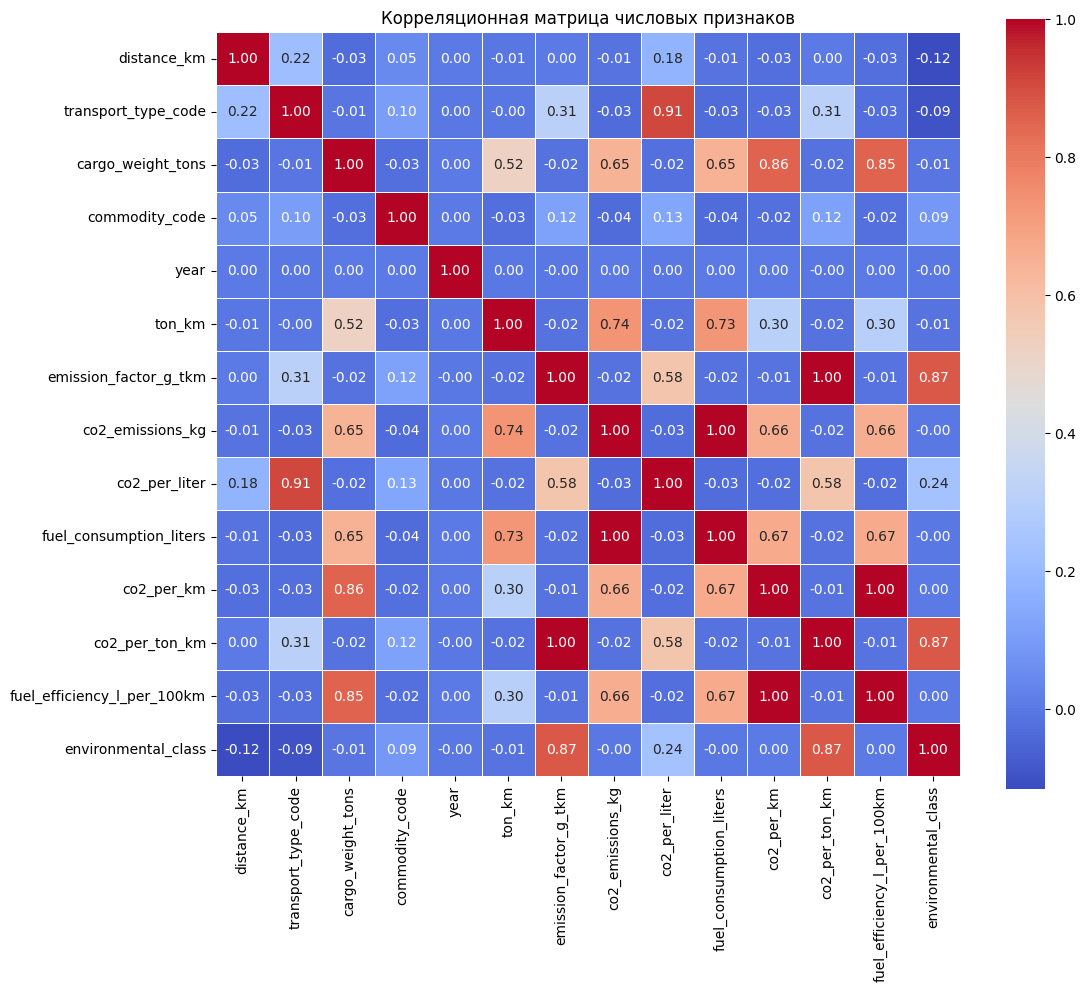

In [58]:
# Посмотрим ещё раз на корреляцию числовых признаков
correlation_matrix = copy.corr(method='pearson', numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
)
plt.title('Корреляционная матрица числовых признаков')

Мы видим, что у показателя общего кол-ва выбросов в рейсе (freight_emission) сильная корреляция между весом груза, грузооборотом, выбросами CO2 на километр и эффективностью топлива и стопроцентная свезь с потреблением топлива в литрах. При этом, код транспортного средства так же близко к полной корреляции с выделением CO2 на литр. Более того, environmental_class сильно связан с интенсивностью выбросов: 0.87. Всё это говорит о том, что можно за таргет брать разные метрики, исключая из признаков взаимозаменяющие признаки.

Возьмём за таргет общие выбросы: **freight_emission**

Предикторами выберем:

* transport_type_code - основной признак + сильная корреляция в 0.91 с co2_per_liter, что очвевидно определяет эффективность топлива
* cargo_weight_tons - вес груза влияет на расход топлива и выбросы
* distance_km - видимо, влияние нелинейное, так как косвено связано с выбросами и транспортом
* commodity_code - код груза так же связан нелинейно, но может оказаться полезен как косвеный фактор

# Pre-processing & feature engineering

In [36]:
features = [
    'distance_km',
    'cargo_weight_tons',
    'transport_type_code',
    'commodity_code',
]

X_train = copy[features]

Возьмём Случайный лес, т.к. он хорошо ведёт себя с категориальными признаками

In [61]:
copy.co2_emissions_kg

,co2_emissions_kg
5308987,3.861600e-08
11730566,2.894816e-04
6562794,2.714705e-04
2083785,8.533653e-05
3731953,1.180831e-02
...,...
2179648,5.027996e-04
8961864,5.631500e-06
4148863,6.786762e-05
243508,7.694045e-03


In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Работаем с копиями
train = copy.copy()
load = pd.read_csv('logistics_dataset_test.csv')
test = load.copy()

# Удалим записи с близкими к нулю выбросами CO2
train = train[train['co2_emissions_kg'] > 1e-3].copy()
test = test[test['co2_emissions_kg'] > 1e-3].copy()

# Логарифмируем целевую переменную
train['log_co2'] = np.log1p(train['co2_emissions_kg'])
test['log_co2'] = np.log1p(test['co2_emissions_kg'])

# Берём признаки
features = [
    'distance_km',
    'cargo_weight_tons',
    'transport_type_code',
    'commodity_code',
]

# === 5. Обработка категориальных признаков ===
categorical = ['transport_type_code', 'commodity_code']

# Объединяем train и test, чтобы одинаково закодировать
combined = pd.concat([train[features], test[features]])
combined_encoded = pd.get_dummies(combined, columns=categorical)

# Разделим обратно
X_train = combined_encoded.iloc[:len(train), :].reset_index(drop=True)
X_test = combined_encoded.iloc[len(train):, :].reset_index(drop=True)

y_train = train['log_co2'].reset_index(drop=True)
y_test = test['log_co2'].reset_index(drop=True)

# Обучаем модель
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Предсказываем и потенцируем признаки
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_true = np.expm1(y_test)

# Оцениваем
mae = mean_absolute_error(y_test_true, y_pred)
print(f"MAE (в кг CO₂): {mae:.2f}")
print(f"RMSE: {root_mean_squared_error(y_test_true, y_pred):.2f}")
print(f"r2 score: {r2_score(y_test_true, y_pred):.2f}")

MAE (в кг CO₂): 0.03
RMSE: 1.18
r2 score: 0.93


In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

features = ['distance_km', 'cargo_weight_tons', 'transport_type_code', 'commodity_code']
target = 'co2_emissions_kg'

X_train = copy.copy()
y_train = copy['co2_emissions_kg']

X_test = load.copy()
y_test = load['co2_emissions_kg']

y_train_scaled = y_train * 1e9
y_test_scaled = y_test * 1e9

numeric_features = ['distance_km', 'cargo_weight_tons']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_features = ['transport_type_code', 'commodity_code']
categorical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100, max_depth=6, random_state=42
    ))
])

model.fit(X_train, y_train_scaled)

y_pred_scaled = model.predict(X_test)

mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(root_mean_squared_error(y_test_scaled, y_pred_scaled))
r2 = r2_score(y_test_scaled, y_pred_scaled)

print(f" MAE: {mae:.3f} г CO₂")
print(f" RMSE: {rmse:.3f} г CO₂")
print(f" R² Score: {r2:.3f}")
print(f" MAE в % от среднего: {mae / y_test_scaled.mean() * 100:.2f}%")

📊 MAE: 29431628.135 г CO₂
📊 RMSE: 28490.994 г CO₂
📊 R² Score: 0.928
📊 MAE в % от среднего: 16.30%
